# Covid-19 Genome Analysis Notebook

## GOAL: Plot Covid-19 Mutations
[Covid-19 Genomes](https://www.ncbi.nlm.nih.gov/genbank/sars-cov-2-seqs/)

## About:
I want to play around with coronavirus genome. I found this really cool article
[here](https://blog.floydhub.com/exploring-dna-with-deep-learning/) where they talked about one-hot encoding a genome 
and plotting it. I want to see if I could apply that to the corona virus. My results are below.


In [195]:
from Bio import Entrez
from Bio import SeqIO
import os
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

##  Search NCBI Data Online
Manually compile a list of genome ids we will use. These genome IDs will be used to download the genebank files from the
NCBI database.

In [196]:
Entrez.email = "daniel.delvin.diaz+ncbi@gmail.com"  # Always tell NCBI who you are
# List of genomes
# MN908947 -> Ref Genome
genbank_ids = ['MN908947', 'LC534418.1', 'MN985325.1', 'MN988713.1', 'MT077125.1', 'MT093571.1', 'MT044258.1', 'MT039888.1', 'MT039887.1', 'MT027062.1', 'MT019531.1']

## Print out one of the results so we can inspect it.

In [197]:
# Ref Genome: NC_045512
for g in genbank_ids:
    handle = Entrez.efetch(db="nucleotide", id=g, rettype="gb", retmode="text")
    text = handle.read()
    # print(text)
    assert text is not None
    break

## Download all the genomes from our search and store them as .gb files.
- store them in the generated/ folder

In [198]:
count = 0
for genome_id in genbank_ids:
    filename = f'{os.path.abspath(".")}/generated/genBankRecord_{genome_id}.gb'
    # Lets not download the genome if we already have it.
    if os.path.isfile(filename):
        print('Skipping:{}'.format(filename))
        continue

    record = Entrez.efetch(db="nucleotide", id=genome_id, rettype="gb", retmode="text")

    print('Writing:{}'.format(filename))
    with open(filename, 'w') as f:
        f.write(record.read())
    # Im noticing some really wonky file permissions with jupyter notebook and pycharm
    # going to force it to be this:
    # Dont forget this is python3 specific syntax
    os.chmod(filename, 0o666)


Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MN908947.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_LC534418.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MN985325.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MN988713.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MT077125.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MT093571.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MT044258.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MT039888.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MT039887.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MT027062.1.gb
Skipping:/Users/ddiaz/src/corona/generated/genBankRecord_MT019531.1.gb


## Download ref genome for sars-covid-2
## Which btw was made with an Illumina Genome Sequencer! :) Nice
Note: I also source controlled this file, so there is no need to download it.

In [199]:
def download_ref_genome():
    Entrez.email = "daniel.delvin.diaz+ncbi@gmail.com"  # Always tell NCBI who you are
    record = Entrez.efetch(db="nucleotide", id="MN908947", rettype="gb", retmode="text")
    filename = f'{os.path.abspath(".")}/ref_genome/genBankRecord_ref.gb'
    with open(filename, 'w') as f:
        content = record.read()
        f.write(content)
    print('File Written:{}'.format(filename))

# Note I have noticed a weird behavior with pycharm + jupyter notebook where you wont see the
# file locally unless you click out of pycharm then back in.

# download_ref_genome()


## Load Genome Functions

In [200]:
def load_ref_genome():
    ref_genome_path = f"{os.path.abspath('.')}/ref_genome/genBankRecord_ref.gb"
    ref_genome_seq = None
    for seq_record in SeqIO.parse("./ref_genome/genBankRecord_ref.gb", "genbank"):
        ref_genome_seq = seq_record.seq
    return ref_genome_seq

In [201]:
# Generic Load Functions
def load_genomes(folder_path=os.path.abspath('.')+"/generated/"):
    f = []
    print(f"Using folder {folder_path} to load genomes")
    for (root, dirnames, filenames) in os.walk(folder_path):
        for filename in filenames:
            f.append(os.path.join(root,filename))
    genomes = []
    for genome_file in f:
        print(f"Getting genome from file {genome_file}")
        for seq_record in SeqIO.parse(genome_file, "genbank"):
            genome_seq = str(seq_record.seq)
            # Lets assume theres one genome per file
            genomes.append(genome_seq)
    return genomes

## Munge the genomes

Not all the genomes are the same len. I am attempting to make them the same size as the ref genome, and adding a z
whenever i do any padding.

Eventually I would want to figure out a better way to align the genomes, or take the different sizes into account as that is prob significant.

In [202]:
def munged_genomes():
    g = load_genomes()
    ref_g = g[0]

    munged_genomes = []
    for genome in g:
        if len(genome) < len(ref_g):
            # Need to extend genome so len matches
            m_genome = genome.ljust(len(ref_g), 'z')
            munged_genomes.append(m_genome)
        elif len(genome) > len(ref_g):
            munged_genomes.append(genome[:len(ref_g)])
        else:
            munged_genomes.append(genome)

    # Sanity Check
    l = len(ref_g)
    for x in munged_genomes:
        assert len(x) == l

    return munged_genomes

In [203]:
# Compute the munged genome sequences
munged_genome_sequences = munged_genomes()

Using folder /Users/ddiaz/src/corona/generated/ to load genomes
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MT044258.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MN988713.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MT027062.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MN908947.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MT077125.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MT039888.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MT019531.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MT039887.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MN985325.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRecord_MT093571.1.gb
Getting genome from file /Users/ddiaz/src/corona/generated/genBankRe

## Set up functions to transform the genome into its one-hot encoded form.

In [204]:
######################################
# Setup One Hot Encoding Function
######################################

# One hot encode a DNA sequence string
# non 'acgt' bases (n) are 0000
# returns a L x 4 numpy array

label_encoder = LabelEncoder()
# z is also used when genomes are unequal in size.
label_encoder.fit(np.array(['a','c','g','t','z']))

def string_to_array(my_string):
    my_string = my_string.lower()
    my_string = re.sub('[^acgt]', 'z', my_string)
    my_array = np.array(list(my_string))
    return my_array

def one_hot_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    # n_values is very important, it ensures all the ecoded genomes are nx5
    # note: n_values was deprecated, have to use categories instead
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int, categories=[range(5)])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_encoded = np.delete(onehot_encoded, -1, 1)
    return onehot_encoded




In [205]:
# Test one hot encoder
def test_one_hot_encoder():
    test_sequence = 'AACGCGGTTNN'
    test_sequence_hot = one_hot_encoder(string_to_array(test_sequence))
    expected_sequence_hot =   [[1, 0, 0, 0],
                               [1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 1, 0],
                               [0, 1, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1],
                               [0, 0, 0, 1],
                               [0, 0, 0, 0],
                               [0, 0, 0, 0]]

    # Lets check this function is working as expected
    assert np.array_equal(test_sequence_hot, expected_sequence_hot)

In [206]:
test_one_hot_encoder()


## One Hot Encode ref genome.

In [207]:
# r = ref_genome_seq[0:5]
ref_seq_hot = one_hot_encoder(string_to_array(str(load_ref_genome())))

# DEV Note: Because there are no unknown letters in the ref genome, the output hot encoding is only 3 positions instead of
# 4 like in the test above.
# We can force this to be 4, by updating the one hot encoding function to take in a categories variable, which is what we have done.
# print(ref_seq_hot)

#### Quick note:
Notice then above array is only 3 bits
```text
[1 0 0]
A 1 in the first position means A.
A 1 in the second position means C.
A 1 in the third position means G.
And all zeros means T
```

## Let's create a generic function that does the genome load and one hot encoding

In [208]:
def get_one_hot_genome_encoding(munged_genome_sequence):
    """
    :returns A one hot encode genome
    """
    genome_seq = str(munged_genome_sequence)
    seq_hot = one_hot_encoder(string_to_array(genome_seq))
    return seq_hot


## Lets get all the one hot encodings for the gb files we have

In [209]:
def get_one_hot_genome_encodings(munged_genome_sequences):
    result = []
    for genome in munged_genome_sequences:
        r = get_one_hot_genome_encoding(genome)
        result.append(r)
    return result

In [210]:
one_hot_encoded_genomes = get_one_hot_genome_encodings(munged_genome_sequences)

# print("Array of one hot encoded genomes")
# print(one_hot_encoded_genomes)


## Next step is to try and generate the mutation diagram
- Each row will be an different seq.
- Below is a test mutation diagram.

[0, 0, 0]
[0, 0, 1]
[[0, 0, 0], [0, 0, 0], [0, 0, 1]]


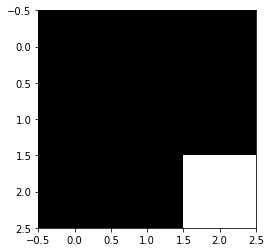

In [211]:
# ACG
g1_ref = [[1,0,0,0],[0,1,0,0],[0,0,1,0]]
# ACG
g2 = [[1,0,0,0],[0,1,0,0],[0,0,1,0]]
# ACT
# This one has a mutation in the 3rd letter
g3 = [[1,0,0,0],[0,1,0,0],[0,0,0,1]]

# Two options, we can either compare to the ref genome, or compare to an array that represents
# the most common letter in that position

# Lets start with the former, then move to the latter
# A final zero bit (black) will be ref genome
# A one (white) will be mutation from ref genome

# X = np.random.random((100, 100)) # sample 2D array
# plt.imshow(X, cmap="gray")
# plt.show()

# this is our basline, all zeros
genome_chart = [[0]*len(g1_ref)]
# print(genome_chart)

def compare(ref_genome, new_genome):
    i = 0
    result = []
    for i in range(len(ref_genome)):
        if np.array_equal(ref_genome[i], new_genome[i]):
            result.append(0)
        else:
            result.append(1)
    return result

result1 = compare(g1_ref,g2)
print(result1)
result2 = compare(g1_ref,g3)
print(result2)
genome_chart.append(result1)
genome_chart.append(result2)
print(genome_chart)

plt.imshow(genome_chart, cmap="gray")
plt.show()

## Ok let's pause.
Above we created 3 sample genomes that were only 3 letters long. one was the ref genome.
Only one genome had a mutation in the last position.
So if we compare that to the chart, the top row is the ref genome, its all black becuase its the ref.
THe bottom row is the mutated genome, with the last column, last row being white as thats were the mutation is.


In [212]:
# Now lets do the same thing to the 3 genomes we have.
g1 = ref_seq_hot
gN = one_hot_encoded_genomes
# imchart requires floats
genome_chart = [[float(0)]*len(g1)]

In [213]:
def compare_with_fudging(ref_genome, new_genome):
    # TODO: this func shouldnt be needed anymore cause we did some munging earlier
    i = 0
    result = []
    for i in range(len(ref_genome)):
        # check if arrays are equal, if not write a 1
        # sometimes arrays arent equal. for now, lets just assume thats a mutation
        try:
            if np.array_equal(ref_genome[i], new_genome[i]):
                result.append(float(0))
        except IndexError:
            result.append(float(1))
        else:
            result.append(float(1))
    return result


In [214]:
for genome in gN[:]:
    c = compare_with_fudging(g1,genome)
    genome_chart.append(c)

# for some reason i am getting a type error when i do the full array, for now , lets justt do a partial.
# genome_chart_debug = [genome_chart[0][:500], genome_chart[1][:500], genome_chart[2][:500]]
genome_chart_debug = []
for arr in genome_chart:
    genome_chart_debug.append(arr[250:300])

## Plot the genome mutation matrix

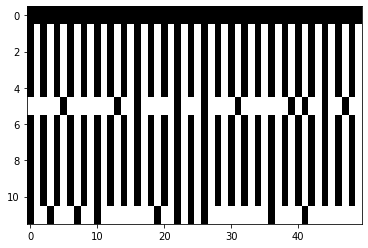

In [215]:
# plt.figure(figsize = (15,5))
plt.imshow(np.real(genome_chart_debug), cmap="gray", interpolation="nearest", aspect='auto')
plt.show()

## Results
Above you will see 50 base pairs (Position 250->300). The black bar at the top being the ref genome, and the white lines representing mutations.

## What can be improved
- Right now I am only using a few genomes, and only a subset of the genome, so the chart still looks funky, and is not the checkerboard I was expecting.
- Also, I did not take into consideration actually aligning the genome.
- I also added some fudge factor for unequal genome lengths.
- Everything is being compared against the ref genome. It would probably be more interesting to derive the most common letter for that position, then label one wild, and one mutation.

## Useful Links:
http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc132
https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-ml
